In [4]:
import os, re, glob
import numpy as np
import imageio.v2 as iio
import matplotlib.pyplot as plt
from typing import List, Tuple


In [5]:
# ---------------------------
# User config
# ---------------------------
proj_dir   = "figs/projections/chest/projections"     # 你的投影图目录
pattern    = "deg_*.png"       # 文件模式：如 "deg_*.png" 或 "*.png"
a, b       = 90, 180            # 角度范围，包含端点；如果 a > b 视为穿越 360°（如 300->30）
mode       = "mean"             # {"row", "sum", "mean"}:
row_index  = None              # mode="row" 时使用的行索引；None 表示取中间行
normalize  = False             # 是否把每个切片的行向量归一化（可选）

In [6]:
# ---------------------------
# Helpers
# ---------------------------
angle_regexes = [
    re.compile(r"[^\d](\d{1,3})(?=[^\d]*$)"),   # 末尾的数字块，如 "..._123.png"
    re.compile(r"deg[_\-]?(\d{1,3})", re.IGNORECASE),  # "deg_000" 或 "deg-000"
]

def extract_angle(fname: str) -> int | None:
    base = os.path.basename(fname)
    for rgx in angle_regexes:
        m = rgx.search(base)
        if m:
            return int(m.group(1)) % 360
    # 兜底：抓第一个数字串
    m = re.search(r"(\d{1,3})", base)
    return (int(m.group(1)) % 360) if m else None

def angle_in_range(theta: int, a: int, b: int) -> bool:
    """含端点。若 a<=b 普通区间；若 a>b 视为跨 360°（如 300->30）"""
    if a <= b:
        return a <= theta <= b
    else:
        return theta >= a or theta <= b

def to_gray_float(img: np.ndarray) -> np.ndarray:
    if img.ndim == 3 and img.shape[2] >= 3:
        if np.issubdtype(img.dtype, np.floating):
            gray = img[..., :3].mean(axis=2).astype(np.float32)
        else:
            gray = img[..., :3].astype(np.float32).mean(axis=2)
    elif img.ndim == 2:
        gray = img.astype(np.float32)
    else:
        raise ValueError(f"Unsupported image shape: {img.shape}")
    return gray

In [7]:
# ---------------------------
# Gather and filter files
# ---------------------------
files = sorted(glob.glob(os.path.join(proj_dir, pattern)))
if not files:
    raise ValueError(f"No files matched: {os.path.join(proj_dir, pattern)}. "
                     f"请确认目录与文件名模式（例如 deg_000.png）。")

pairs: List[Tuple[int, str]] = []
for f in files:
    ang = extract_angle(f)
    if ang is None:
        # 跳过无法解析角度的文件
        continue
    if angle_in_range(ang, a, b):
        pairs.append((ang, f))

if not pairs:
    raise ValueError(f"在角度区间 [{a}, {b}] 内没有匹配到任何文件。"
                     f"尝试放宽区间，或检查文件名是否含有角度数字。")

# 按角度排序
pairs.sort(key=lambda x: x[0])

# ---------------------------
# Build sinogram
# ---------------------------
sinogram_columns = []
angles_sorted = []

for ang, f in pairs:
    img = to_gray_float(iio.imread(f))
    H, W = img.shape

    if mode == "row":
        ri = H // 2 if row_index is None else int(row_index)
        if not (0 <= ri < H):
            raise ValueError(f"row_index={ri} 超出范围 [0, {H-1}]")
        vec = img[ri, :]              # shape (W,)
    elif mode == "sum":
        vec = img.sum(axis=0)         # 对垂直方向求和 -> (W,)
    elif mode == "mean":
        vec = img.mean(axis=0)        # 对垂直方向求平均 -> (W,)
    else:
        raise ValueError(f"未知 mode: {mode}")

    vec = vec.astype(np.float32)
    if normalize:
        vmax = np.max(vec)
        if vmax > 0:
            vec = vec / vmax

    sinogram_columns.append(vec)
    angles_sorted.append(ang)

# 形状统一校验
widths = {v.shape for v in sinogram_columns}
if len(widths) != 1:
    # 若不同投影的宽度不一致，给出提示
    raise ValueError(f"检测到不一致的 detector 宽度: {widths}。请确保所有投影同宽。")

# 组合为 (detector_position, num_angles)
S = np.stack(sinogram_columns, axis=1)

print(f"Sinogram shape = {S.shape}, angles = {len(angles_sorted)} "
      f"({angles_sorted[0]}° → {angles_sorted[-1]}°{' (wrap)' if a>b else ''})")

Sinogram shape = (256, 31), angles = 31 (90° → 180°)


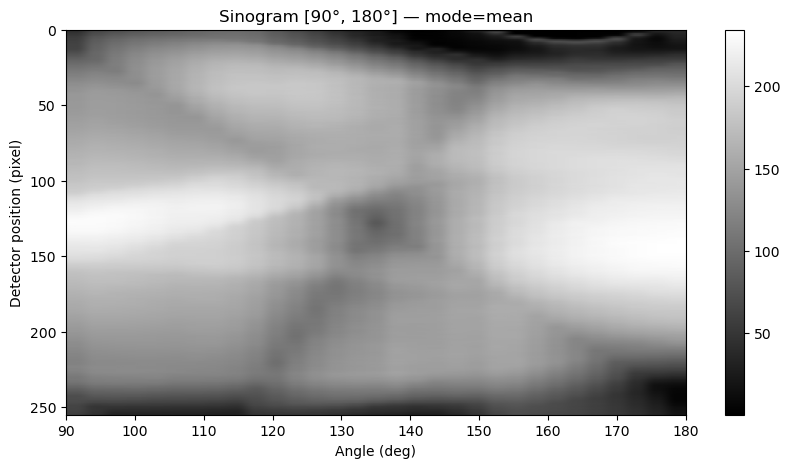

In [8]:
# ---------------------------
# Plot
# ---------------------------
plt.figure(figsize=(10, 5))
plt.imshow(S, cmap="gray", aspect="auto",
           extent=[angles_sorted[0], angles_sorted[-1], S.shape[0]-1, 0])
plt.xlabel("Angle (deg)")
plt.ylabel("Detector position (pixel)")
plt.title(f"Sinogram [{a}°, {b}°] — mode={mode}"
          + (f", row={H//2 if row_index is None else row_index}" if mode=='row' else ""))
plt.colorbar()
plt.show()